# Forecasting count of Bikes rented

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.


You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

## Data Fields

datetime - hourly date + timestamp 

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

# Linear Regression

## Agenda

1. Introducing the bikeshare dataset
    - Reading in the data
    - Visualizing the data
2. Working with multiple features
    - Visualizing the data (part 2)
    - Adding more features to the model

## Reading in the data

We'll be working with a dataset from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

In [1]:
# read the data and set the datetime as the index
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [2]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Questions:**

- What does each observation represent?
- What is the response variable (as defined by Kaggle)?
- How many features are there?

In [3]:
# "count" is a method, so it's best to name that column something else
bikes.rename(columns={'count':'total'}, inplace=True)

## Visualizing the data

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

/Users/kvsdileep/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


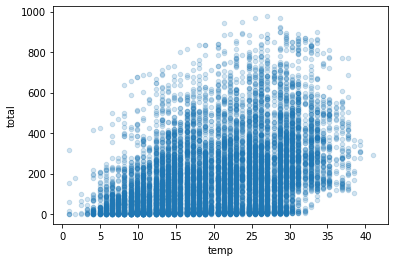

In [5]:
# Pandas scatter plot
bikes.plot(kind='scatter', x='temp', y='total', alpha=0.2)

## Visualizing the data (part 2)

In [6]:
# explore more features
feature_cols = ['temp', 'season', 'weather', 'humidity']

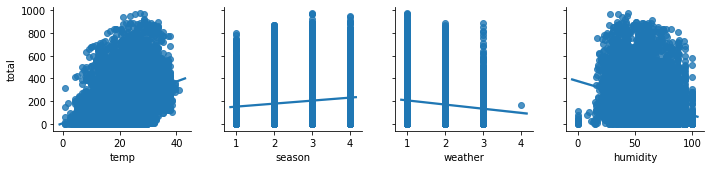

In [7]:
# multiple scatter plots in Seaborn
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total', kind='reg')

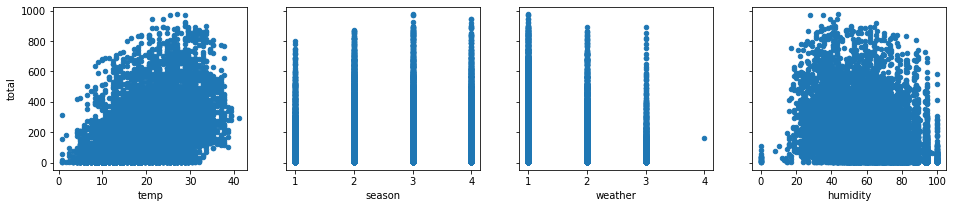

In [8]:
# multiple scatter plots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes.plot(kind='scatter', x=feature, y='total', ax=axs[index], figsize=(16, 3))

Are you seeing anything that you did not expect?

In [9]:
# cross-tabulation of season and month
pd.crosstab(bikes.season, bikes.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


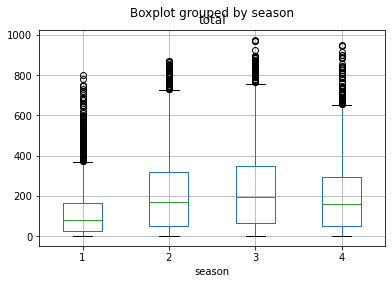

In [10]:
# box plot of rentals, grouped by season
bikes.boxplot(column='total', by='season')

Notably:

- A line can't capture a non-linear relationship.
- There are more rentals in winter than in spring (?)

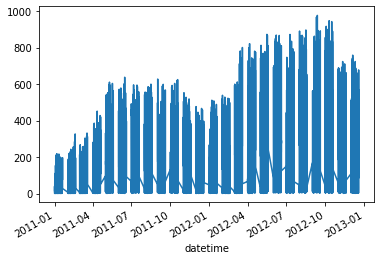

In [11]:
# line plot of rentals
bikes.total.plot()

What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing **overall growth** and the winter months happen to come after the spring months.

In [12]:
# correlation matrix (ranges from 1 to -1)
bikes.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


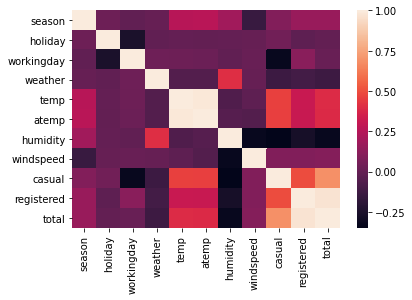

In [13]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bikes.corr())

You have just seen how to explore the data and look for patterns. 